In [1]:
import numpy as np
import pandas as pd
import os 

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model


def get_avaibable_gpus():
    local_device_protos = device_lib.list_local_devices()
    return[x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_avaibable_gpus())

2024-06-02 07:21:17.961049: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 07:21:17.961153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 07:21:18.073662: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['/device:GPU:0']


In [2]:
df = pd.read_csv('/kaggle/input/badguygoodguy/BadGuyGoodGuy/character.csv')
df.head(5)

,class index,filepaths,labels,data set
0,0,train/savory/0001.jpg,savory,train
1,0,train/savory/0002.jpg,savory,train
2,0,train/savory/0003.jpg,savory,train
3,0,train/savory/0004.jpg,savory,train
4,0,train/savory/0005.jpg,savory,train


In [3]:
datasets = df.groupby('data set')
train_df = datasets.get_group('train')
test_df = datasets.get_group('test')
valid_df = datasets.get_group('valid')

In [4]:
train_df.head()

,class index,filepaths,labels,data set
0,0,train/savory/0001.jpg,savory,train
1,0,train/savory/0002.jpg,savory,train
2,0,train/savory/0003.jpg,savory,train
3,0,train/savory/0004.jpg,savory,train
4,0,train/savory/0005.jpg,savory,train


In [5]:
train_df['filepaths'] = train_df['filepaths'].apply(lambda x: os.path.join('/kaggle/input/badguygoodguy/BadGuyGoodGuy', x))
test_df['filepaths'] = test_df['filepaths'].apply(lambda x: os.path.join('/kaggle/input/badguygoodguy/BadGuyGoodGuy', x))
valid_df['filepaths'] = valid_df['filepaths'].apply(lambda x: os.path.join('/kaggle/input/badguygoodguy/BadGuyGoodGuy', x))

/tmp/ipykernel_24/289702821.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['filepaths'] = train_df['filepaths'].apply(lambda x: os.path.join('/kaggle/input/badguygoodguy/BadGuyGoodGuy', x))
/tmp/ipykernel_24/289702821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['filepaths'] = test_df['filepaths'].apply(lambda x: os.path.join('/kaggle/input/badguygoodguy/BadGuyGoodGuy', x))
/tmp/ipykernel_24/289702821.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [6]:
train_df

,class index,filepaths,labels,data set
0,0,/kaggle/input/badguygoodguy/BadGuyGoodGuy/trai...,savory,train
1,0,/kaggle/input/badguygoodguy/BadGuyGoodGuy/trai...,savory,train
2,0,/kaggle/input/badguygoodguy/BadGuyGoodGuy/trai...,savory,train
3,0,/kaggle/input/badguygoodguy/BadGuyGoodGuy/trai...,savory,train
4,0,/kaggle/input/badguygoodguy/BadGuyGoodGuy/trai...,savory,train
...,...,...,...,...
11215,1,/kaggle/input/badguygoodguy/BadGuyGoodGuy/trai...,unsavory,train
11216,1,/kaggle/input/badguygoodguy/BadGuyGoodGuy/trai...,unsavory,train
11217,1,/kaggle/input/badguygoodguy/BadGuyGoodGuy/trai...,unsavory,train
11218,1,/kaggle/input/badguygoodguy/BadGuyGoodGuy/trai...,unsavory,train


In [7]:
image_size = (300,300)
batch_size = 16

train_generator = ImageDataGenerator(horizontal_flip=True)
valid_test_generator = ImageDataGenerator()

train_data = train_generator.flow_from_dataframe(
    train_df, 
    x_col = 'filepaths',
    y_col = "labels",
    target_size = image_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)

test_data = valid_test_generator.flow_from_dataframe(
    test_df,
    x_col = "filepaths",
    y_col = "labels",
    target_size = image_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = batch_size
)

valid_data = valid_test_generator.flow_from_dataframe(
    valid_df,
    x_col = "filepaths",
    y_col = 'labels',
    target_size = image_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = batch_size
)

Found 11220 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


In [8]:
eff_model = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top = False,
    weights = 'imagenet',
    input_shape = (image_size[0],image_size[1],3),
    pooling = 'max'
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
eff_model.trainable = True

x = eff_model.output
x = BatchNormalization()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(2, activation = 'softmax')(x)

model = Model(inputs = eff_model.input, outputs = outputs)
lr = 0.001


model.compile(optimizer = Adamax(learning_rate = lr),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])



In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

ckpoint = ModelCheckpoint(
    "best_weights_model.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    mode = 'auto'
)

In [11]:
epochs = 10
model.fit(
    x = train_data,
    epochs = epochs,
    validation_data = valid_data,
    # callbacks = [ckpoint]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1717313059.093673      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717313059.255343      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8694 - loss: 0.3331

W0000 00:00:1717313304.937863      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


702/702 ━━━━━━━━━━━━━━━━━━━━ 411s 367ms/step - accuracy: 0.8694 - loss: 0.3329 - val_accuracy: 0.9817 - val_loss: 0.1031
Epoch 2/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 146s 207ms/step - accuracy: 0.9498 - loss: 0.1419 - val_accuracy: 0.9700 - val_loss: 0.0987
Epoch 3/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 146s 207ms/step - accuracy: 0.9689 - loss: 0.0917 - val_accuracy: 0.9800 - val_loss: 0.0493
Epoch 4/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 145s 206ms/step - accuracy: 0.9809 - loss: 0.0591 - val_accuracy: 0.9850 - val_loss: 0.0523
Epoch 5/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 145s 206ms/step - accuracy: 0.9865 - loss: 0.0357 - val_accuracy: 0.9733 - val_loss: 0.0754
Epoch 6/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 202s 207ms/step - accuracy: 0.9881 - loss: 0.0345 - val_accuracy: 0.9767 - val_loss: 0.0547
Epoch 7/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 146s 207ms/step - accuracy: 0.9867 - loss: 0.0380 - val_accuracy: 0.9850 - val_loss: 0.0569
Epoch 8/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 201s 206ms/step - accuracy: 0.9919 - loss: 0.02

In [12]:
# model = tf.keras.models.load_model('/kaggle/working/best_weights_model.keras')

In [13]:
class_indices = list(train_data.class_indices.values())
class_names = list(train_data.class_indices.keys())
class_indices,class_names

([0, 1], ['savory', 'unsavory'])

In [14]:
results_1 = model.evaluate(test_data)

print('Test Loss: {:.2f}%'.format(results_1[0]*100))
print('Test Accuracy: {:.2f}%'.format(results_1[1]*100))

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9880 - loss: 0.0377
Test Loss: 4.82%
Test Accuracy: 98.33%


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
savory 0


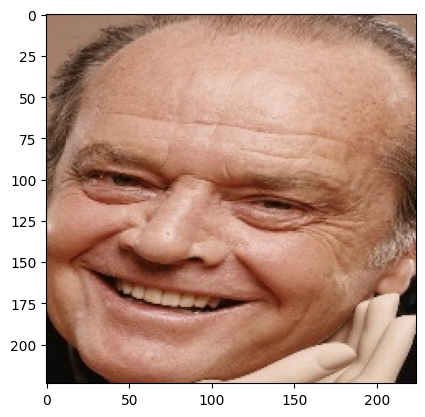

In [15]:
from PIL import Image
image_url = '/kaggle/input/badguygoodguy/BadGuyGoodGuy/test/savory/007.jpg'

img = Image.open(image_url).resize((300,300))
img = np.array(img)

pred = model.predict(img[None,:,:])[0]
index = np.argmax(pred)

print(class_names[index], class_indices[index])

plt.imshow(Image.open(image_url))
plt.show()                         

In [16]:
eff_model.save('eff_model_good_bad_guy.h5')